# Introduction

In this notebook, we perform exploration on the 2023 NSDUH data with the goals of: 

1) Learning more about the demographic characteristics of multiracial young adults aged 18-25 
2) Learning more about the substance use and mental health patterns among multiracial young adults
3) Examining initial associations between illicit substance use and mental health

To accomplish goal 1, we create bar plots that reveal frequencies of demographics among multiracial young adults such as income, household composition, and education. 

To accomplish goal 2, we create bar plots to examine substance use and mental health patterns.

To accomplish goal 3, we do a combination of bar plots with variability measures and inferential statistics to capture initial associations between illicit substance use and mental health outcomes.

By learning more about the demographic characteristics of multiracial young adults, we gain an important understanding of potential mediators towards the relationship between substance use and mental health when it comes time to do our main analysis. For example, if we learn that multiracial young adults are generally from households with lower median income, it would make sense if there is a strong association between illicit substance use and mental health outcomes because multiracial young adults from areas of lower median household income are more likely to experience more stress.

By learning more about substance use and mental health patterns among multiracial young adults, we can gain an initial understanding on why multiracial young adults is an important population to be studied in health-related research: their tendency to experience more substance use and mental health issues (as outlined in the 2023 NSDUH national report). 

By examining initial associations between illicit substance use and mental health, we can gain an initial understanding on how illicit substance use is associated with mental health outcomes among multiracial young adults, motivating us to dive deeper into areas where there is a clear association shown between illicit substance use and mental health.

In [328]:
#Import modules
import os #file path
import pandas as pd #Access, modify, and manipulate data
import matplotlib.pyplot as plt #Data visualization
import seaborn as sns #Data visualization 
import numpy as np #Numerical computation
from samplics.categorical import Tabulation #Survey design
from samplics.estimation import TaylorEstimator #Survey design
from samplics.utils.types import PopParam #Survey design
#Base path to GitHub repository
path="C:/Users/John Platt/OneDrive/DA301Project/John-Platt-DA-401-Project"
#Directory where the project data is
datadir="data"

In [329]:
#Read in the cleaned 2023 NSDUH dataset
nsduh_2023 = pd.read_csv(os.path.join(path, datadir, "NSDUH_2023.csv"))

In [330]:
#Delete first column of the data that has the row numbers (starts at 1)
nsduh_2023.drop('Unnamed: 0', axis=1, inplace=True) 
#Print out the dataset
nsduh_2023

,ANALWT2_C,VESTR_C,VEREP,IRSEX,CATAGE,NEWRACE2,EDUHIGHCAT,IRWRKSTAT18,IRHHSIZ2,IRPRVHLT,...,IRHALLUCYFQ,IRALCBNG30D,SUTINPPY,IRDSTNRV12,IRDSTEFF12,IRIMPCONCN,IRSUICTHNK,IRAMDEYR,MHTINPPY,AMISUD5ANYO
0,3276.469874,40031,2,Male,4,7,Some coll/Assoc Dg,Other (incl. not in labor force),Three people in household,Yes,...,0,7,No,LEGITIMATE SKIP,LEGITIMATE SKIP,LEGITIMATE SKIP,No,No,No,Neither SUD or AMI
1,15630.082955,40021,2,Male,4,1,High school grad,Employed full time,Three people in household,No,...,0,5,No,Some of the time,Most of the time,Mild difficultly,No,No,No,SUD and AMI
2,4018.172390,40043,1,Female,4,4,High school grad,Other (incl. not in labor force),Three people in household,No,...,0,0,No,LEGITIMATE SKIP,LEGITIMATE SKIP,Mild difficultly,No,Yes,No,SUD and AMI
3,10711.709540,40030,2,Male,1,7,12 to 17 year olds,12-17 year olds,Five people in household,No,...,0,0,No,LEGITIMATE SKIP,LEGITIMATE SKIP,LEGITIMATE SKIP,NaN,NaN,No,NaN
4,8195.104779,40023,2,Male,4,6,College graduate,Employed full time,Three people in household,Yes,...,0,0,No,LEGITIMATE SKIP,LEGITIMATE SKIP,LEGITIMATE SKIP,No,No,No,Neither SUD or AMI
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56700,417.630119,40018,2,Female,4,7,Less high school,Employed part time,Four people in household,No,...,0,0,No,LEGITIMATE SKIP,LEGITIMATE SKIP,LEGITIMATE SKIP,No,No,No,Neither SUD or AMI
56701,7625.717934,40017,1,Female,4,1,Some coll/Assoc Dg,Other (incl. not in labor force),Four people in household,Yes,...,0,0,No,Most of the time,None of the time,No difficulty,No,No,No,Neither SUD or AMI
56702,23556.083908,40042,1,Female,4,1,College graduate,Employed full time,One person in household,Yes,...,3,5,No,LEGITIMATE SKIP,LEGITIMATE SKIP,LEGITIMATE SKIP,No,No,No,Neither SUD or AMI
56703,5193.882625,40040,2,Male,4,5,College graduate,Other (incl. not in labor force),Two people in household,No,...,0,0,No,LEGITIMATE SKIP,LEGITIMATE SKIP,No difficulty,No,No,No,Neither SUD or AMI


In [331]:
def rel_frequencies(df,xvar,na_rm=True):
    '''
    Compute weighted frequencies (including accounting for survey design)
    across demographics 

    Parameters:
    df - object - Cleaned 2023 NSDUH dataframe
    xvar - string - The substance use variable that will be generate an average from
    na_rm - boolean - Whether or not we will eliminate missing values

    Return:
    Table with frequencies and 95% confidence intervals
    '''
    # Work on a copy to avoid modifying original df
    df = df.copy()
    #Create new column based on where there are multiracial young adults in the cleaned dataset
    df["subpop_xvar"]=df[xvar].where((df["CATAGE"] == 2) & (df["NEWRACE2"] == 6), np.nan)
    #Tabulation function calculates and tabulates summary statistics of a categorical variable given
    #survey weights and survey design measures
    #We account for the subpopulation (multiracial young adults) WHEN we do the tabulation 
    #Don't filter data down to multiracial young adults before doing the tabulation as 
    #that would bias the SE/variance estimates towards that specific subgroup rather than the total population
    #Tabulation with full dataset, but subpopulation defined
    tab = Tabulation(PopParam.prop)  
    tab.tabulate(
        #Column we want to tabulate relative frequencies based on 
        vars=df[["subpop_xvar"]],
        #2023 NSDUH sample weight
        samp_weight=df["ANALWT2_C"],
        #Variance stratum
        stratum=df["VESTR_C"],
        #Variance primary sampling unit
        psu=df["VEREP"],
        remove_nan=na_rm
    )
    #Convert the weighted frequency estimates to a dataframe
    df=tab.to_dataframe()
    #Sort the frequency dataframe by frequencies in descending order
    df.sort_values(by=PopParam.prop,ascending=False,inplace=True)
    return df

In [332]:
def rel_freq_barplot(df,xvar,xlabel,xaxisrotation,title):
    '''
    Given a dataframe, creates barplot for relative frequencies of one variable
    
    Parameters:
    df - object - Cleaned 2023 NSDUH dataframe
    xvar - string - The variable that will be the x-axis of our barplot (variable that we will show proportions of)
    xlabel - string - The x-axis label of our barplot
    xaxisrotation - integer - How much we should rotate the x-axis tick labels (0 to 360 degrees)
    title - string - The title of our barplot

    Return:
    The frequency table
    '''   
    #Create table with weighted relative frequency estimates 
    df=rel_frequencies(df,xvar,na_rm=True)
    #Create percentage column
    df['Percentage']=df[PopParam.prop]*100
    #Create column that has the lower bound of 95% CI expressed as a percentage
    df['Lower_ci_percentage']=df["lower_ci"]*100
    #Create column that has the upper bound of 95% CI expressed as a percentage
    df['Upper_ci_percentage']=df["upper_ci"]*100
    #Create new column that calculates the lower error based on the percentage subtracted to the Lower_ci_percentage
    df['lower_error']=df["Percentage"]-df['Lower_ci_percentage']
    #Create new column that calculates the upper error based on the percentage subtracted to the Upper_ci_percentage
    df['upper_error']=df['Upper_ci_percentage']-df["Percentage"]
    #Put lower and upper measures into a list
    asymmetric_err=[df['lower_error'],df['upper_error']]
    #Create bar plot with error bars
    plot=plt.bar(df['category'],df['Percentage'], yerr=asymmetric_err, capsize=5, color=sns.color_palette('Spectral', n_colors=len(df)))
    #Add data labels to bar plot
    plt.bar_label(plot,fmt="%.2f",label_type='center')
    #Change x-axis label of plot
    plt.xlabel(xlabel)
    #Change y-axis label of plot
    plt.ylabel("Weighted Proportion (%)")
    #Change title of plot
    plt.title(title)
    #Change rotation angle of x-axis tick labels of plot
    plt.xticks(rotation=xaxisrotation)
    #Show plot
    plt.show()
    #Return frequency table
    return df

In [333]:
def frequencies(df,xvar,na_rm=True):
    '''
    Compute weighted counts (including accounting for survey design)
    across demographics 

    Parameters:
    df - object - Cleaned 2023 NSDUH dataframe
    xvar - string - The demographic variable that will be generate counts from
    na_rm - boolean - Whether or not we will eliminate missing values

    Return:
    Table with frequencies and 95% confidence intervals
    '''
    # Work on a copy to avoid modifying original df
    df = df.copy()
    #Create new column based on where there are multiracial young adults in the cleaned dataset
    df["subpop_xvar"]=df[xvar].where((df["CATAGE"] == 2) & (df["NEWRACE2"] == 6), np.nan)
    #Do tabulation to estimate counts of demographoic variable
    tab = Tabulation(PopParam.count)  
    tab.tabulate(
        #Column we want to tabulate relative frequencies based on 
        vars=df[["subpop_xvar"]],
        #2023 NSDUH sample weight
        samp_weight=df["ANALWT2_C"],
        #Variance stratum
        stratum=df["VESTR_C"],
        #Variance primary sampling unit
        psu=df["VEREP"],
        remove_nan=na_rm
    )
    totals=tab.to_dataframe()
    return totals

In [334]:
def avg_tbl(df,xvar,na_rm=True):
    '''
    Compute weighted mean (including accounting for survey design)
    across substance use measures

    Parameters:
    df - object - Cleaned 2023 NSDUH dataframe
    xvar - string - The substance use variable that will be generate an average from
    na_rm - boolean - Whether or not we will eliminate missing values

    Return:
    Table with substance use averages (for multiracial young adults and all other populations) and 95% confidence intervals
    '''
    # Work on a copy to avoid modifying original df
    df = df.copy()
    #Create new domain variable based on where there are multiracial young adults in the cleaned dataset
    #This will be used when accounting for subgroup analysis in the taylor estimation
    domain=((df["CATAGE"] == 2) & (df["NEWRACE2"] == 6)).astype(int)
    #Taylor estimator for mean substance use frequency
    est = TaylorEstimator(PopParam.mean)
    est.estimate(
        y=df[xvar], #Substance use variable calculating the mean frequency on
        samp_weight=df['ANALWT2_C'], #Sample weight
        stratum=df['VESTR_C'], #Variance stratum
        psu=df['VEREP'], #Primary sampling unit
        domain=domain, #pass subgroup vector
        remove_nan=na_rm
    )
    #to_dataframe() is handy when domain is provided (row per domain level)
    out = est.to_dataframe()
    #Change values of domain column to be more descriptive
    out['_domain'] = out['_domain'].replace({1: 'Multiracial Young Adults', 0: 'All Other Populations'})
    #Sort the dataframe in descending order by the mean estimates
    out.sort_values(by='_estimate',ascending=False,inplace=True)
    #Return dataframe with mean (accounts for complex survey design)
    return out

In [335]:
def mean_comp(df,xvar,xlabel,xaxisrotation,title):
    '''
    Create bar plots with error bars that compare substance use averages between multiracial young adults aged 18-25 and
    all other populations

    Parameters:
    df - object - Cleaned 2023 NSDUH dataframe
    xvar - string - The variable that will be the x-axis of our barplot (variable that we will show averages of)
    xlabel - string - The x-axis label of our barplot
    xaxisrotation - integer - How much we should rotate the x-axis tick labels (0 to 360 degrees)
    title - string - The title of our barplot

    Return:
    The averages table
    '''    
    df=df.copy()
    #Obtain averages table
    df=avg_tbl(df,xvar,na_rm=True)
    #Create new column that calculates the lower error based on the average subtracted to the _lci
    df['lower_error']=df['_estimate']-df['_lci']
    #Create new column that calculates the upper error based on the average subtracted to the _uci
    df['upper_error']=df['_uci']-df['_estimate']
    #Put lower and upper measures into a list
    asymmetric_err=[df['lower_error'],df['upper_error']]
    #Create bar plot with error bars
    plot=plt.bar(df['_domain'],df['_estimate'], yerr=asymmetric_err, capsize=5, color=sns.color_palette('Spectral', n_colors=len(df)))
    #Add data labels to bar plot
    plt.bar_label(plot,fmt="%.2f",label_type='center')
    #Change x-axis label of plot
    plt.xlabel(xlabel)
    #Change y-axis label of plot
    plt.ylabel("Weighted Average")
    #Change title of plot
    plt.title(title)
    #Change rotation angle of x-axis tick labels of plot
    plt.xticks(rotation=xaxisrotation)
    #Show plot
    plt.show()
    #Return averages table
    return df
    

In [393]:
def avg_tbl2(df,xvar,yvar,na_rm=True):
    '''
    Compute weighted mean (including accounting for survey design)
    across substance use measures by mental health measures

    Parameters:
    df - object - Cleaned 2023 NSDUH dataframe
    xvar - string - The substance use variable that will be generate an average from
    yvar - string - The mental health variable we are comparing substance use measures across
    na_rm - boolean - Whether or not we will eliminate missing values
    Return:
    Table with substance use averages (for multiracial young adults and all other populations) and 95% confidence intervals
    '''
    # Work on a copy to avoid modifying original df
    df = df.copy()
    #Create domain series for multiracial young adults who have experienced the specified mental health issue (yvar)
    domain_yes = ((df["CATAGE"]==2) & (df["NEWRACE2"]==6) & (df[yvar]=='Yes')).astype(int)
    #Taylor estimator for mean substance use frequency for mental health group 1 (multiracial young adults 
    #who experienced the mental health issue in the past year)
    est = TaylorEstimator(PopParam.mean)
    est.estimate(
        y=df[xvar],
        samp_weight=df["ANALWT2_C"],
        stratum=df["VESTR_C"],
        psu=df["VEREP"],
        domain=domain_yes,
        remove_nan=na_rm
    )
    #to_dataframe() is handy when domain is provided (row per domain level)
    out1 = est.to_dataframe()
    #Change values of domain column to be more descriptive
    out1['_domain'] = out1['_domain'].replace({1: 'Yes', 0: 'All Other Populations'})
    #Create domain series for multiracial young adults who have NOT experienced the specified mental health issue (yvar)
    domain_no = ((df["CATAGE"]==2) & (df["NEWRACE2"]==6) & (df[yvar]=='No')).astype(int)
    #Taylor estimator for mean substance use frequency for mental health group 2 (multiracial young 
    #adults who did not experience the mental health issue in the past year)
    est = TaylorEstimator(PopParam.mean)
    est.estimate(
        y=df[xvar],
        samp_weight=df["ANALWT2_C"],
        stratum=df["VESTR_C"],
        psu=df["VEREP"],
        domain=domain_no,
        remove_nan=na_rm
    )
    #to_dataframe() is handy when domain is provided (row per domain level)
    out2 = est.to_dataframe()
    #Change values of domain column to be more descriptive
    out2['_domain'] = out2['_domain'].replace({1: 'No', 0: 'All Other Populations'})
    #Combine the two dataframes, taking the row of each dataframe where _domain=Group 1 or _domain=Group 2
    group_comp=pd.concat([out1.loc[out1['_domain']=='Yes',:],out2.loc[out2['_domain']=='No',:]])
    #Sort the combined dataframe
    group_comp.sort_values(by='_estimate',ascending=False,inplace=True)
    #Return dataframe with mean (accounts for complex survey design) illicit substance use for each group
    return group_comp

In [394]:
def mean_comp2(df,xvar,yvar,xlabel,xaxisrotation,title):
    '''
    Create bar plots with error bars that compare substance use averages between multiracial young adults aged 18-25 and
    all other populations

    Parameters:
    df - object - Cleaned 2023 NSDUH dataframe
    xvar - string - The illicit substance use variable that will be the y-axis of our barplot (variable that we will show averages of)
    yvar - string - The mental health variable that will be on the x-axis of our barplot
    xlabel - string - The x-axis label of our barplot
    xaxisrotation - integer - How much we should rotate the x-axis tick labels (0 to 360 degrees)
    title - string - The title of our barplot

    Return:
    The averages table 
    '''    
    df=df.copy()
    #Obtain averages table
    df=avg_tbl2(df,xvar,yvar,na_rm=True)
    #Create new column that calculates the lower error based on the average subtracted to the _lci
    df['lower_error']=df['_estimate']-df['_lci']
    #Create new column that calculates the upper error based on the average subtracted to the _uci
    df['upper_error']=df['_uci']-df['_estimate']
    #Put lower and upper measures into a list
    asymmetric_err=[df['lower_error'],df['upper_error']]
    #Create bar plot with error bars
    plot=plt.bar(df['_domain'],df['_estimate'], yerr=asymmetric_err, capsize=5, color=sns.color_palette('Spectral', n_colors=len(df)))
    #Add data labels to bar plot
    plt.bar_label(plot,fmt="%.2f",label_type='center')
    #Change x-axis label of plot
    plt.xlabel(xlabel)
    #Change y-axis label of plot
    plt.ylabel("Weighted Average")
    #Change title of plot
    plt.title(title)
    #Change rotation angle of x-axis tick labels of plot
    plt.xticks(rotation=xaxisrotation)
    #Show plot
    plt.show()
    #Return averages table
    return df

# Understanding Our Sample

In this section, we accomplish goal 1 outlined in the introduction. 

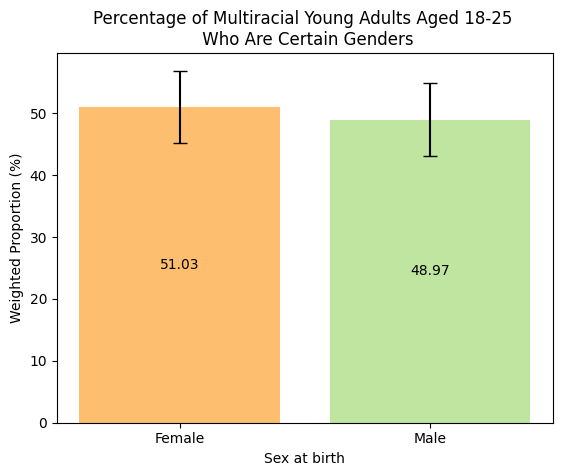

,variable,category,PopParam.prop,stderror,lower_ci,upper_ci,Percentage,Lower_ci_percentage,Upper_ci_percentage,lower_error,upper_error
0,subpop_xvar,Female,0.510336,0.029394,0.451426,0.568961,51.033622,45.142555,56.896118,5.891066,5.862496
1,subpop_xvar,Male,0.489664,0.029394,0.431039,0.548574,48.966378,43.103882,54.857445,5.862496,5.891066


In [337]:
#Examine gender frequencies among multiracial young adults aged 18-25
rel_freq_barplot(nsduh_2023,'IRSEX','Sex at birth',0,"Percentage of Multiracial Young Adults Aged 18-25 \n Who Are Certain Genders")

In [338]:
#Compute counts/frequencies (weighted to represent the totals for multiracial young adults in the U.S. population)
frequencies(nsduh_2023,'IRSEX',na_rm=True)

,variable,category,PopParam.count,stderror,lower_ci,upper_ci
0,subpop_xvar,Female,569606.755414,41632.630363,485985.156337,653228.354491
1,subpop_xvar,Male,546533.424846,45168.493689,455809.835267,637257.014425


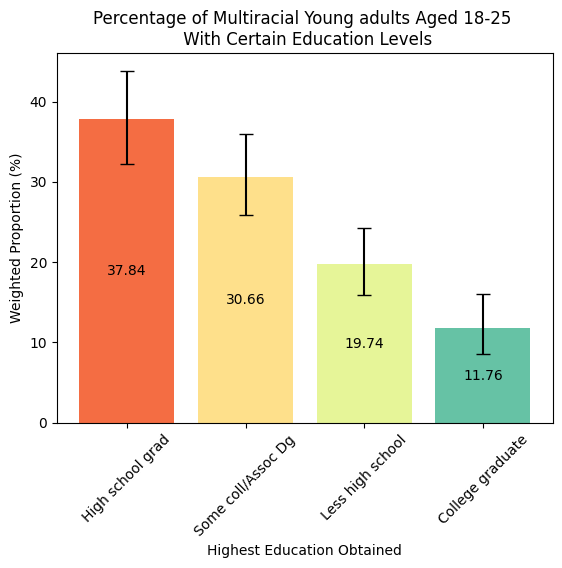

,variable,category,PopParam.prop,stderror,lower_ci,upper_ci,Percentage,Lower_ci_percentage,Upper_ci_percentage,lower_error,upper_error
1,subpop_xvar,High school grad,0.378426,0.029159,0.321863,0.438501,37.842563,32.186251,43.850137,5.656312,6.007574
3,subpop_xvar,Some coll/Assoc Dg,0.306586,0.025330,0.258181,0.359665,30.658561,25.818102,35.966529,4.840460,5.307968
2,subpop_xvar,Less high school,0.197377,0.020736,0.159002,0.242345,19.737697,15.900152,24.234546,3.837545,4.496849
0,subpop_xvar,College graduate,0.117612,0.018496,0.085237,0.160130,11.761178,8.523724,16.013023,3.237454,4.251845


In [339]:
#Examine education frequencies among multiracial young adults aged 18-25
rel_freq_barplot(nsduh_2023,'EDUHIGHCAT','Highest Education Obtained',45,"Percentage of Multiracial Young adults Aged 18-25 \n With Certain Education Levels")


In [340]:
#Compute counts/frequencies (weighted to represent the totals for multiracial young adults in the U.S. population)
frequencies(nsduh_2023,'EDUHIGHCAT',na_rm=True)

,variable,category,PopParam.count,stderror,lower_ci,upper_ci
0,subpop_xvar,College graduate,131271.237758,22388.123375,86303.368551,176239.106965
1,subpop_xvar,High school grad,422376.053533,38098.220292,345853.526011,498898.581054
2,subpop_xvar,Less high school,220300.366201,25228.231191,169627.972560,270972.759841
3,subpop_xvar,Some coll/Assoc Dg,342192.522768,33576.490523,274752.156776,409632.888760


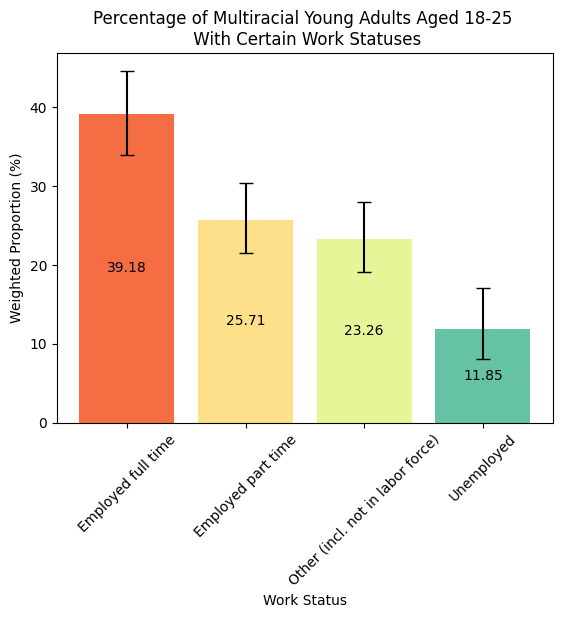

,variable,category,PopParam.prop,stderror,lower_ci,upper_ci,Percentage,Lower_ci_percentage,Upper_ci_percentage,lower_error,upper_error
0,subpop_xvar,Employed full time,0.391783,0.026799,0.339457,0.446720,39.178335,33.945739,44.672027,5.232596,5.493692
1,subpop_xvar,Employed part time,0.257089,0.022311,0.214874,0.304381,25.708857,21.487425,30.438109,4.221432,4.729253
2,subpop_xvar,Other (incl. not in labor force),0.232638,0.022405,0.190685,0.280621,23.263771,19.068460,28.062057,4.195311,4.798286
3,subpop_xvar,Unemployed,0.118490,0.022357,0.080415,0.171236,11.849038,8.041536,17.123619,3.807502,5.274581


In [341]:
#Examine work status among multiracial young adults aged 18-25
rel_freq_barplot(nsduh_2023,'IRWRKSTAT18','Work Status',45,"Percentage of Multiracial Young Adults Aged 18-25 \n With Certain Work Statuses")

In [342]:
#Compute counts/frequencies (weighted to represent the totals for multiracial young adults in the U.S. population)
frequencies(nsduh_2023,'IRWRKSTAT18',na_rm=True)

,variable,category,PopParam.count,stderror,lower_ci,upper_ci
0,subpop_xvar,Employed full time,437285.136400,31569.153800,373876.624873,500693.647927
1,subpop_xvar,Employed part time,286946.877485,28928.636113,228842.001820,345051.753150
2,subpop_xvar,Other (incl. not in labor force),259656.293579,29111.522032,201184.080734,318128.506424
3,subpop_xvar,Unemployed,132251.872796,27650.789073,76713.628446,187790.117146


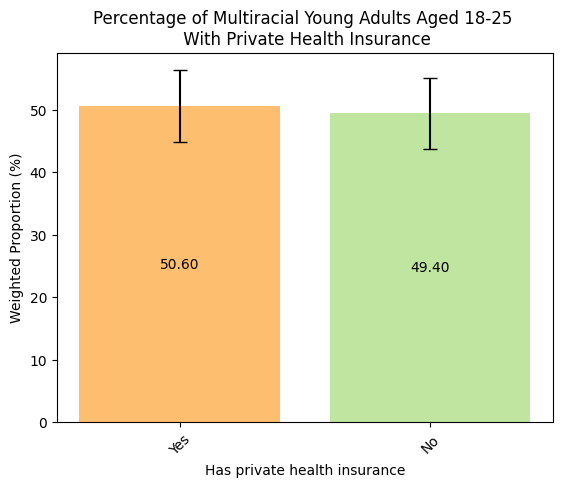

,variable,category,PopParam.prop,stderror,lower_ci,upper_ci,Percentage,Lower_ci_percentage,Upper_ci_percentage,lower_error,upper_error
1,subpop_xvar,Yes,0.505952,0.02872,0.448442,0.563306,50.595225,44.844181,56.330561,5.751044,5.735335
0,subpop_xvar,No,0.494048,0.02872,0.436694,0.551558,49.404775,43.669439,55.155819,5.735335,5.751044


In [343]:
#Examine private health insurance frequencies among multiracial young adults aged 18-25
rel_freq_barplot(nsduh_2023,'IRPRVHLT','Has private health insurance',45,"Percentage of Multiracial Young Adults Aged 18-25 \n With Private Health Insurance")

In [344]:
#Compute counts/frequencies (weighted to represent the totals for multiracial young adults in the U.S. population)
frequencies(nsduh_2023,'IRPRVHLT',na_rm=True)

,variable,category,PopParam.count,stderror,lower_ci,upper_ci
0,subpop_xvar,No,551426.540931,43822.072788,463407.317321,639445.764541
1,subpop_xvar,Yes,564713.639329,41956.910420,480440.704589,648986.574068


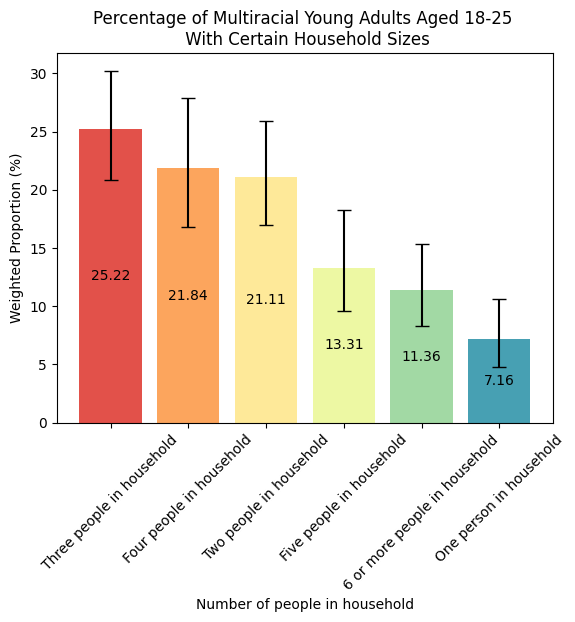

,variable,category,PopParam.prop,stderror,lower_ci,upper_ci,Percentage,Lower_ci_percentage,Upper_ci_percentage,lower_error,upper_error
4,subpop_xvar,Three people in household,0.252202,0.023506,0.207964,0.302259,25.220190,20.796413,30.225871,4.423777,5.005681
2,subpop_xvar,Four people in household,0.218382,0.027706,0.167823,0.279065,21.838185,16.782265,27.906493,5.055920,6.068309
5,subpop_xvar,Two people in household,0.211077,0.022252,0.169829,0.259215,21.107684,16.982908,25.921468,4.124776,4.813784
1,subpop_xvar,Five people in household,0.133136,0.021469,0.095595,0.182445,13.313560,9.559502,18.244457,3.754058,4.930897
0,subpop_xvar,6 or more people in household,0.113646,0.017499,0.082948,0.153800,11.364622,8.294829,15.379965,3.069793,4.015343
3,subpop_xvar,One person in household,0.071558,0.014233,0.047729,0.105958,7.155759,4.772941,10.595799,2.382818,3.440040


In [345]:
#Examine household size frequencies among multiracial young adults aged 18-25
rel_freq_barplot(nsduh_2023,'IRHHSIZ2','Number of people in household',45,"Percentage of Multiracial Young Adults Aged 18-25 \n With Certain Household Sizes")

In [346]:
#Compute counts/frequencies (weighted to represent the totals for multiracial young adults in the U.S. population)
frequencies(nsduh_2023,'IRHHSIZ2',na_rm=True)

,variable,category,PopParam.count,stderror,lower_ci,upper_ci
0,subpop_xvar,6 or more people in household,126845.111846,21975.398196,82706.225558,170983.998134
1,subpop_xvar,Five people in household,148597.992456,25980.544509,96414.533046,200781.451866
2,subpop_xvar,Four people in household,243744.753433,33310.160419,176839.327198,310650.179667
3,subpop_xvar,One person in household,79868.303672,16131.659998,47466.910990,112269.696353
4,subpop_xvar,Three people in household,281492.672518,29540.054780,222159.726318,340825.618717
5,subpop_xvar,Two people in household,235591.346337,25101.823102,185172.850816,286009.841858


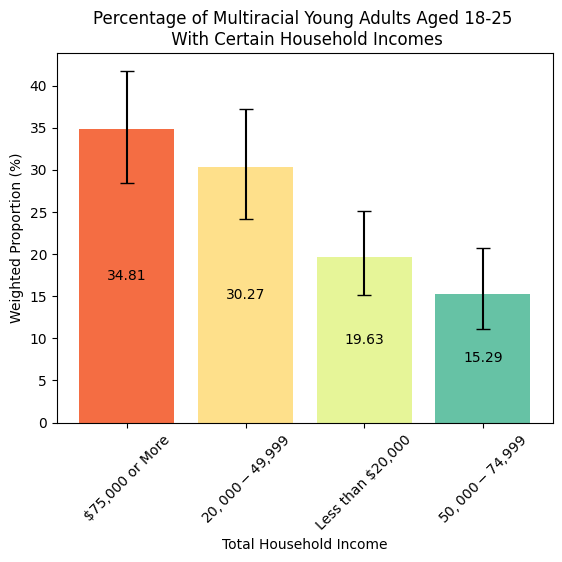

,variable,category,PopParam.prop,stderror,lower_ci,upper_ci,Percentage,Lower_ci_percentage,Upper_ci_percentage,lower_error,upper_error
2,subpop_xvar,"$75,000 or More",0.348091,0.033358,0.284409,0.417710,34.809137,28.440896,41.770952,6.368241,6.961815
0,subpop_xvar,"$20,000-$49,999",0.302700,0.032556,0.241537,0.371759,30.269979,24.153697,37.175913,6.116282,6.905934
3,subpop_xvar,"Less than $20,000",0.196270,0.024696,0.151328,0.250617,19.626950,15.132782,25.061667,4.494168,5.434717
1,subpop_xvar,"$50,000-$74,999",0.152939,0.023902,0.110827,0.207322,15.293933,11.082708,20.732242,4.211225,5.438309


In [347]:
#Examine income frequencies among multiracial young adults aged 18-25
rel_freq_barplot(nsduh_2023,'INCOME','Total Household Income',45,"Percentage of Multiracial Young Adults Aged 18-25 \n With Certain Household Incomes")

In [348]:
#Compute counts/frequencies (weighted to represent the totals for multiracial young adults in the U.S. population) among
#multiracial young adults aged 18-25
frequencies(nsduh_2023,'INCOME',na_rm=True)

,variable,category,PopParam.count,stderror,lower_ci,upper_ci
0,subpop_xvar,"$20,000-$49,999",337855.402853,35672.994900,266204.083890,409506.721815
1,subpop_xvar,"$50,000-$74,999",170701.734596,27809.040523,114845.632855,226557.836337
2,subpop_xvar,"$75,000 or More",388518.764018,44580.613187,298975.967178,478061.560858
3,subpop_xvar,"Less than $20,000",219064.278793,31806.718584,155178.604355,282949.953231


# Examining Substance Use and Mental Health Patterns

In this section, we accomplish goal 2 outlined in the introduction.

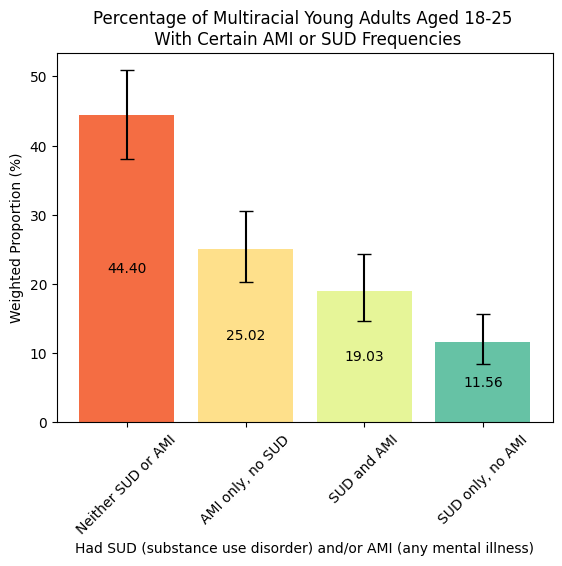

,variable,category,PopParam.prop,stderror,lower_ci,upper_ci,Percentage,Lower_ci_percentage,Upper_ci_percentage,lower_error,upper_error
1,subpop_xvar,Neither SUD or AMI,0.443962,0.032046,0.380875,0.508909,44.396175,38.087457,50.890916,6.308718,6.494741
0,subpop_xvar,"AMI only, no SUD",0.250167,0.025713,0.202128,0.305255,25.016687,20.212802,30.525484,4.803885,5.508797
2,subpop_xvar,SUD and AMI,0.190308,0.024133,0.146467,0.243527,19.030772,14.646685,24.352709,4.384088,5.321936
3,subpop_xvar,"SUD only, no AMI",0.115564,0.017655,0.084549,0.156016,11.556366,8.454938,15.601568,3.101427,4.045202


In [349]:
#Examine co-occurring substance use disorder and any mental illness frequencies among multiracial young adults aged 18-25
rel_freq_barplot(nsduh_2023,'AMISUD5ANYO','Had SUD (substance use disorder) and/or AMI (any mental illness)',45,"Percentage of Multiracial Young Adults Aged 18-25 \n With Certain AMI or SUD Frequencies")
 

In [350]:
#Compute counts/frequencies (weighted to represent the totals for multiracial young adults in the U.S. population)
frequencies(nsduh_2023,'AMISUD5ANYO',na_rm=True)

,variable,category,PopParam.count,stderror,lower_ci,upper_ci
0,subpop_xvar,"AMI only, no SUD",279221.295931,32068.339880,214810.139655,343632.452207
1,subpop_xvar,Neither SUD or AMI,495523.547970,42360.975247,410439.025141,580608.070800
2,subpop_xvar,SUD and AMI,212410.095167,30611.014950,150926.062158,273894.128177
3,subpop_xvar,"SUD only, no AMI",128985.241191,20185.192526,88442.088813,169528.393570


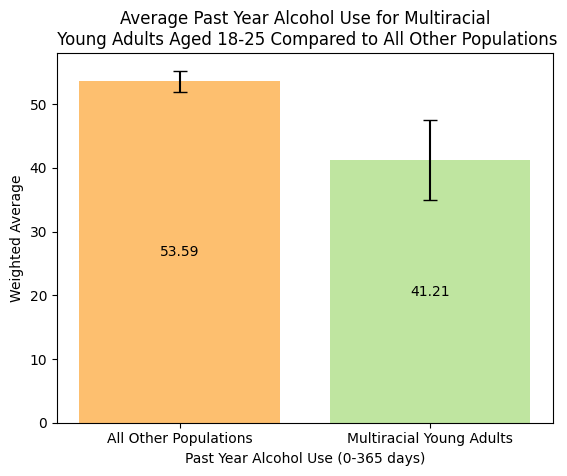

,_param,_domain,_estimate,_stderror,_lci,_uci,_cv,lower_error,upper_error
0,PopParam.mean,All Other Populations,53.590673,0.837397,51.908711,55.272635,0.015626,1.681962,1.681962
1,PopParam.mean,Multiracial Young Adults,41.208199,3.112654,34.956250,47.460147,0.075535,6.251949,6.251949


In [351]:
#Examine average of alcohol use frequency for those that are multiracial young adults vs other populations 
mean_comp(nsduh_2023,"IRALCFY",'Past Year Alcohol Use (0-365 days)',0,'Average Past Year Alcohol Use for Multiracial\n Young Adults Aged 18-25 Compared to All Other Populations')

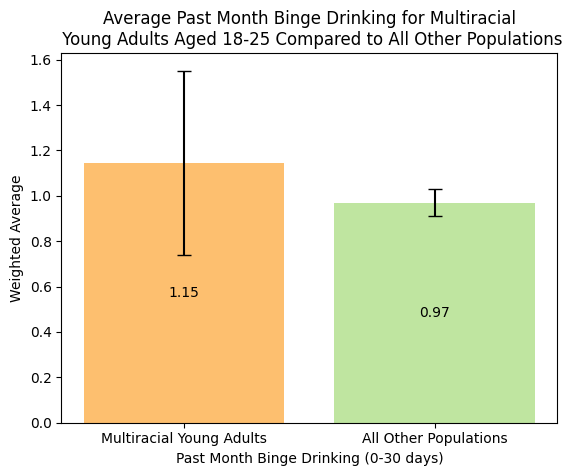

,_param,_domain,_estimate,_stderror,_lci,_uci,_cv,lower_error,upper_error
1,PopParam.mean,Multiracial Young Adults,1.145635,0.202139,0.739627,1.551644,0.176443,0.406009,0.406009
0,PopParam.mean,All Other Populations,0.970480,0.029652,0.910921,1.030039,0.030554,0.059559,0.059559


In [352]:
#Examine average of binge drinking frequency in the past month for those that are multiracial young adults vs other populations 
mean_comp(nsduh_2023,"IRALCBNG30D",'Past Month Binge Drinking (0-30 days)',0,'Average Past Month Binge Drinking for Multiracial\n Young Adults Aged 18-25 Compared to All Other Populations')

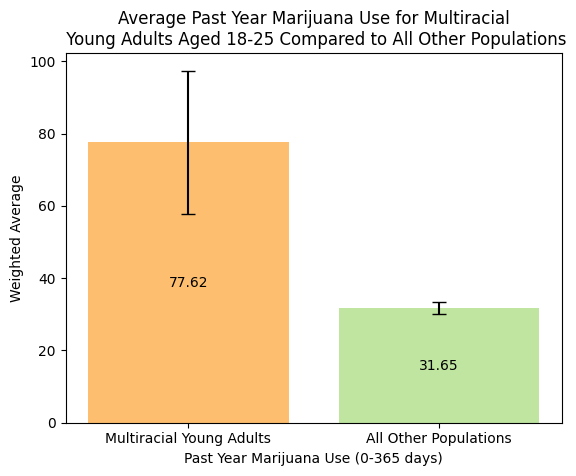

,_param,_domain,_estimate,_stderror,_lci,_uci,_cv,lower_error,upper_error
1,PopParam.mean,Multiracial Young Adults,77.623198,9.859400,57.820010,97.426387,0.127016,19.803188,19.803188
0,PopParam.mean,All Other Populations,31.646210,0.826718,29.985699,33.306722,0.026124,1.660512,1.660512


In [353]:
#Examine average of marijuana use frequency for those that are multiracial young adults vs other populations 
mean_comp(nsduh_2023,"IRMJFY",'Past Year Marijuana Use (0-365 days)',0,'Average Past Year Marijuana Use for Multiracial\n Young Adults Aged 18-25 Compared to All Other Populations')

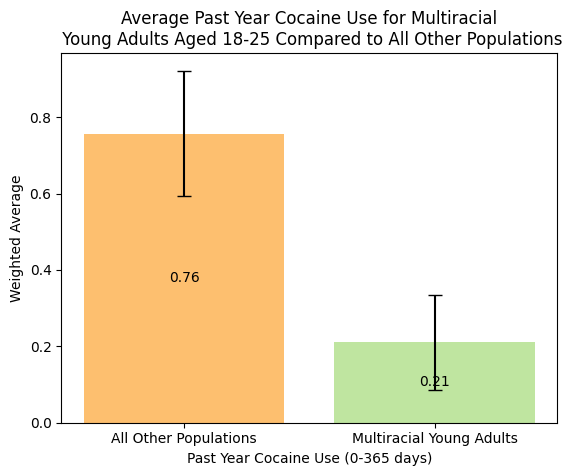

,_param,_domain,_estimate,_stderror,_lci,_uci,_cv,lower_error,upper_error
0,PopParam.mean,All Other Populations,0.757038,0.081840,0.592657,0.921419,0.108106,0.164381,0.164381
1,PopParam.mean,Multiracial Young Adults,0.210826,0.061758,0.086782,0.334870,0.292931,0.124044,0.124044


In [354]:
#Examine average of cocaine frequency for those that are multiracial young adults vs other populations 
mean_comp(nsduh_2023,"IRCOCFY",'Past Year Cocaine Use (0-365 days)',0,'Average Past Year Cocaine Use for Multiracial\n Young Adults Aged 18-25 Compared to All Other Populations')

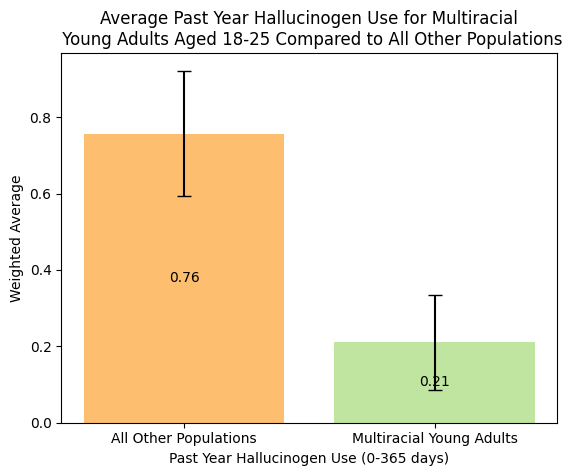

,_param,_domain,_estimate,_stderror,_lci,_uci,_cv,lower_error,upper_error
0,PopParam.mean,All Other Populations,0.757038,0.081840,0.592657,0.921419,0.108106,0.164381,0.164381
1,PopParam.mean,Multiracial Young Adults,0.210826,0.061758,0.086782,0.334870,0.292931,0.124044,0.124044


In [355]:
#Examine average of hallucinogen frequency for those that are multiracial young adults vs other populations 
mean_comp(nsduh_2023,"IRCOCFY",'Past Year Hallucinogen Use (0-365 days)',0,'Average Past Year Hallucinogen Use for Multiracial\n Young Adults Aged 18-25 Compared to All Other Populations')

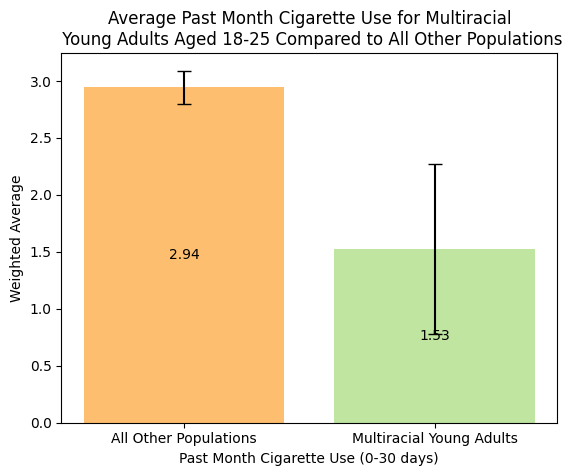

,_param,_domain,_estimate,_stderror,_lci,_uci,_cv,lower_error,upper_error
0,PopParam.mean,All Other Populations,2.943559,0.072982,2.796970,3.090149,0.024794,0.146590,0.146590
1,PopParam.mean,Multiracial Young Adults,1.527265,0.371063,0.781963,2.272566,0.242959,0.745301,0.745301


In [356]:
#Examine average of cigarette frequency in the past month for those that are multiracial young adults vs other populations 
mean_comp(nsduh_2023,"IRCIGFM",'Past Month Cigarette Use (0-30 days)',0,'Average Past Month Cigarette Use for Multiracial\n Young Adults Aged 18-25 Compared to All Other Populations')

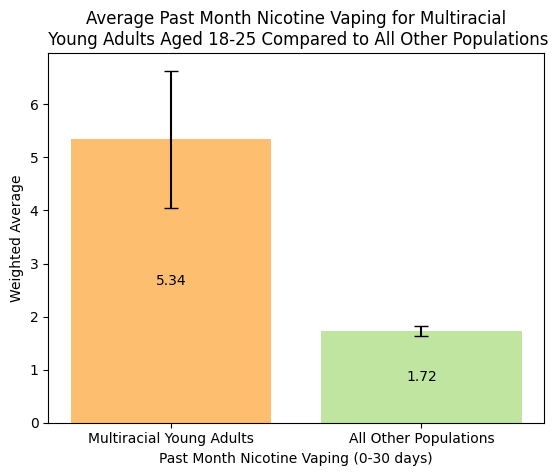

,_param,_domain,_estimate,_stderror,_lci,_uci,_cv,lower_error,upper_error
1,PopParam.mean,Multiracial Young Adults,5.337912,0.644808,4.042776,6.633047,0.120798,1.295135,1.295135
0,PopParam.mean,All Other Populations,1.721527,0.046599,1.627929,1.815125,0.027069,0.093598,0.093598


In [357]:
#Examine average of nicotine vaping frequency in the past month for those that are multiracial young adults vs other populations 
mean_comp(nsduh_2023,"IRNICVAP30N",'Past Month Nicotine Vaping (0-30 days)',0,'Average Past Month Nicotine Vaping for Multiracial\n Young Adults Aged 18-25 Compared to All Other Populations')

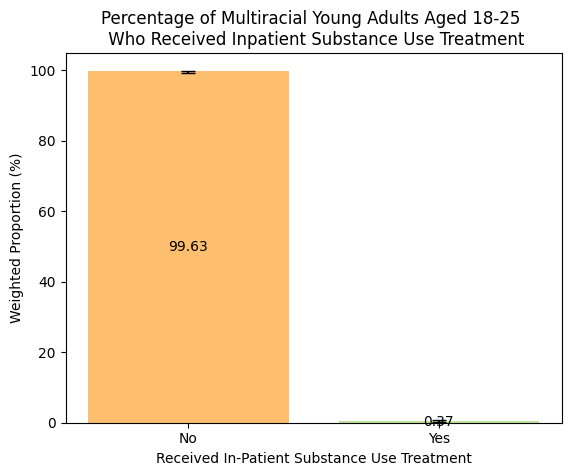

,variable,category,PopParam.prop,stderror,lower_ci,upper_ci,Percentage,Lower_ci_percentage,Upper_ci_percentage,lower_error,upper_error
0,subpop_xvar,No,0.996313,0.001384,0.992175,0.998267,99.631335,99.217502,99.826690,0.413833,0.195355
1,subpop_xvar,Yes,0.003687,0.001384,0.001733,0.007825,0.368665,0.173310,0.782498,0.195355,0.413833


In [358]:
#Examine substance use treatment frequencies among multiracial young adults aged 18-25
rel_freq_barplot(nsduh_2023,'SUTINPPY','Received In-Patient Substance Use Treatment',0,"Percentage of Multiracial Young Adults Aged 18-25 \n Who Received Inpatient Substance Use Treatment")

In [359]:
#Compute counts/frequencies (weighted to represent the totals for multiracial young adults in the U.S. population)
frequencies(nsduh_2023,'SUTINPPY',na_rm=True)

,variable,category,PopParam.count,stderror,lower_ci,upper_ci
0,subpop_xvar,No,1.112025e+06,56715.731501,998108.459765,1.225942e+06
1,subpop_xvar,Yes,4.114821e+03,1579.177780,942.949269,7.286693e+03


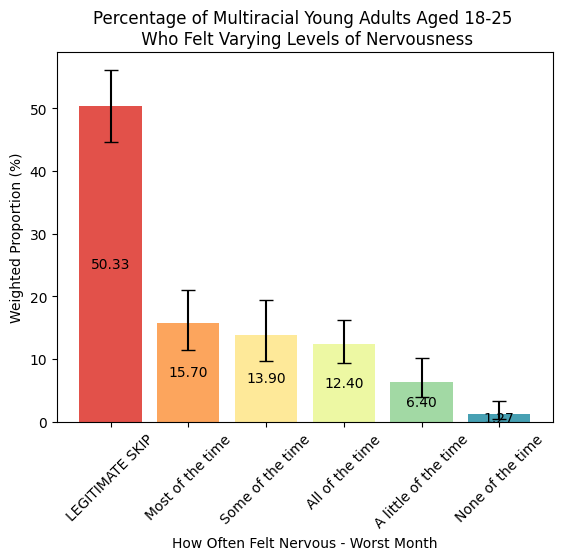

,variable,category,PopParam.prop,stderror,lower_ci,upper_ci,Percentage,Lower_ci_percentage,Upper_ci_percentage,lower_error,upper_error
2,subpop_xvar,LEGITIMATE SKIP,0.503344,0.028858,0.445595,0.561003,50.334384,44.559518,56.100342,5.774866,5.765958
3,subpop_xvar,Most of the time,0.156969,0.023549,0.115231,0.210233,15.696937,11.523149,21.023289,4.173788,5.326351
5,subpop_xvar,Some of the time,0.139040,0.023731,0.097839,0.193863,13.903986,9.783863,19.386314,4.120124,5.482328
1,subpop_xvar,All of the time,0.123956,0.016960,0.093707,0.162221,12.395567,9.370708,16.222076,3.024859,3.826508
0,subpop_xvar,A little of the time,0.063964,0.015009,0.039663,0.101577,6.396362,3.966334,10.157709,2.430029,3.761346
4,subpop_xvar,None of the time,0.012728,0.006073,0.004860,0.032913,1.272763,0.485957,3.291339,0.786805,2.018576


In [360]:
#Examine past year feeling nervous frequencies among multiracial young adults aged 18-25
rel_freq_barplot(nsduh_2023,'IRDSTNRV12','How Often Felt Nervous - Worst Month',45,"Percentage of Multiracial Young Adults Aged 18-25 \n Who Felt Varying Levels of Nervousness")

In [361]:
#Compute counts/frequencies (weighted to represent the totals for multiracial young adults in the U.S. population)
frequencies(nsduh_2023,'IRDSTNRV12',na_rm=True)

,variable,category,PopParam.count,stderror,lower_ci,upper_ci
0,subpop_xvar,A little of the time,71392.370743,16327.218090,38598.188072,104186.553413
1,subpop_xvar,All of the time,138351.908019,21444.110024,95280.145429,181423.670609
2,subpop_xvar,LEGITIMATE SKIP,561802.281876,47241.017677,466915.905356,656688.658396
3,subpop_xvar,Most of the time,175199.823938,27926.277973,119108.243849,231291.404028
4,subpop_xvar,None of the time,14205.815818,6700.366380,747.733872,27663.897764
5,subpop_xvar,Some of the time,155187.979867,25954.449152,103056.934523,207319.025210


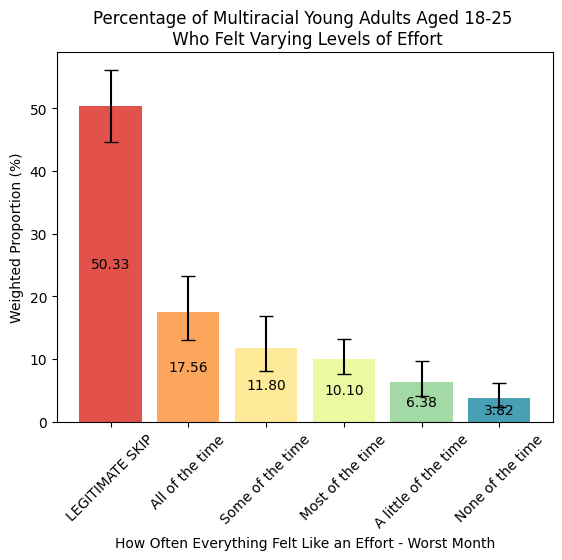

,variable,category,PopParam.prop,stderror,lower_ci,upper_ci,Percentage,Lower_ci_percentage,Upper_ci_percentage,lower_error,upper_error
2,subpop_xvar,LEGITIMATE SKIP,0.503344,0.028858,0.445595,0.561003,50.334384,44.559518,56.100342,5.774866,5.765958
1,subpop_xvar,All of the time,0.175629,0.025246,0.130508,0.232185,17.562939,13.050796,23.218517,4.512143,5.655578
5,subpop_xvar,Some of the time,0.117987,0.021643,0.080960,0.168836,11.798678,8.096035,16.883602,3.702643,5.084924
3,subpop_xvar,Most of the time,0.101024,0.013769,0.076532,0.132231,10.102351,7.653161,13.223106,2.449189,3.120755
0,subpop_xvar,A little of the time,0.063774,0.013528,0.041423,0.096963,6.377352,4.142333,9.696307,2.235019,3.318954
4,subpop_xvar,None of the time,0.038243,0.009545,0.023067,0.062763,3.824296,2.306653,6.276309,1.517643,2.452013


In [362]:
#Examine past year everything felt like an effort frequencies among multiracial young adults aged 18-25
rel_freq_barplot(nsduh_2023,'IRDSTEFF12','How Often Everything Felt Like an Effort - Worst Month',45,"Percentage of Multiracial Young Adults Aged 18-25 \n Who Felt Varying Levels of Effort")

In [363]:
#Compute counts/frequencies (weighted to represent the totals for multiracial young adults in the U.S. population)
frequencies(nsduh_2023,'IRDSTEFF12',na_rm=True)

,variable,category,PopParam.count,stderror,lower_ci,upper_ci
0,subpop_xvar,A little of the time,71180.190890,14838.719248,41375.746132,100984.635647
1,subpop_xvar,All of the time,196027.020356,31713.008521,132329.568119,259724.472593
2,subpop_xvar,LEGITIMATE SKIP,561802.281876,47241.017677,466915.905356,656688.658396
3,subpop_xvar,Most of the time,112756.394944,15972.465704,80674.753411,144838.036477
4,subpop_xvar,None of the time,42684.506323,10478.110970,21638.601056,63730.411589
5,subpop_xvar,Some of the time,131689.785872,23435.371026,84618.457851,178761.113893


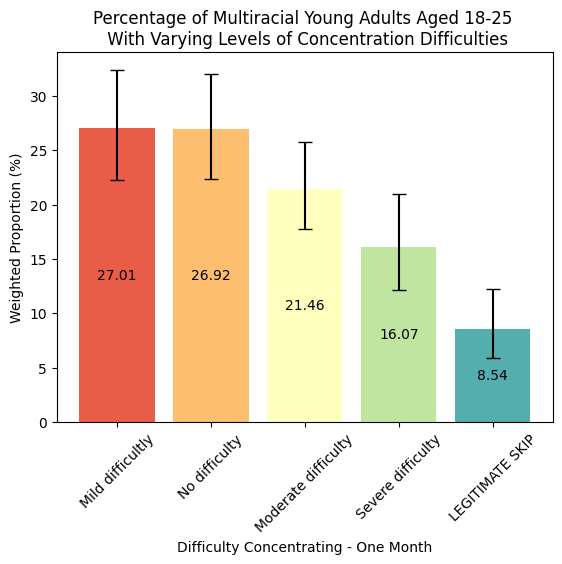

,variable,category,PopParam.prop,stderror,lower_ci,upper_ci,Percentage,Lower_ci_percentage,Upper_ci_percentage,lower_error,upper_error
1,subpop_xvar,Mild difficultly,0.270113,0.025261,0.222457,0.323728,27.011292,22.245672,32.372776,4.765619,5.361484
3,subpop_xvar,No difficulty,0.269197,0.023996,0.223794,0.320013,26.919672,22.379374,32.001336,4.540297,5.081665
2,subpop_xvar,Moderate difficulty,0.214593,0.020011,0.177128,0.257503,21.459328,17.712802,25.750319,3.746526,4.290991
4,subpop_xvar,Severe difficulty,0.160724,0.021810,0.121574,0.209474,16.072352,12.157369,20.947420,3.914983,4.875068
0,subpop_xvar,LEGITIMATE SKIP,0.085374,0.015583,0.058838,0.122320,8.537357,5.883837,12.232042,2.653520,3.694685


In [364]:
#Examine past year difficulty concentrating frequencies among multiracial young adults aged 18-25
rel_freq_barplot(nsduh_2023,'IRIMPCONCN','Difficulty Concentrating - One Month',45,"Percentage of Multiracial Young Adults Aged 18-25 \n With Varying Levels of Concentration Difficulties")

In [365]:
#Compute counts/frequencies (weighted to represent the totals for multiracial young adults in the U.S. population)
frequencies(nsduh_2023,'IRIMPCONCN',na_rm=True)

,variable,category,PopParam.count,stderror,lower_ci,upper_ci
0,subpop_xvar,LEGITIMATE SKIP,95288.867848,17362.342054,60415.577508,130162.158189
1,subpop_xvar,Mild difficultly,301483.878592,29458.103303,242315.536778,360652.220406
2,subpop_xvar,Moderate difficulty,239516.184200,24131.777479,191046.082653,287986.285747
3,subpop_xvar,No difficulty,300461.271189,33204.467751,233768.134925,367154.407452
4,subpop_xvar,Severe difficulty,179389.978432,27963.421474,123223.793424,235556.163440


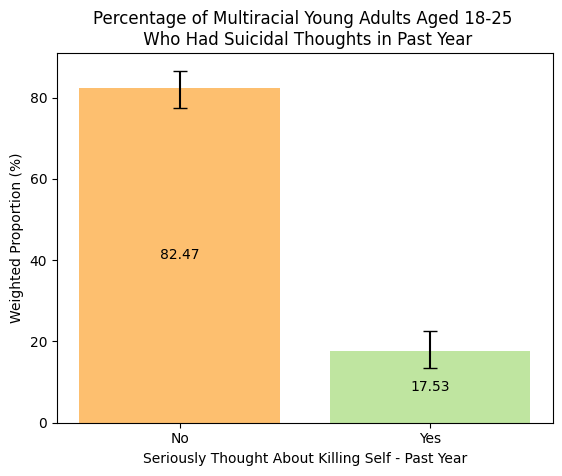

,variable,category,PopParam.prop,stderror,lower_ci,upper_ci,Percentage,Lower_ci_percentage,Upper_ci_percentage,lower_error,upper_error
0,subpop_xvar,No,0.824684,0.023044,0.773516,0.866291,82.468433,77.351624,86.629060,5.116809,4.160626
1,subpop_xvar,Yes,0.175316,0.023044,0.133709,0.226484,17.531567,13.370940,22.648376,4.160626,5.116809


In [366]:
#Examine past year suicidal thoughts frequencies among multiracial young adults aged 18-25
rel_freq_barplot(nsduh_2023,'IRSUICTHNK','Seriously Thought About Killing Self - Past Year',0,"Percentage of Multiracial Young Adults Aged 18-25 \n Who Had Suicidal Thoughts in Past Year")

In [367]:
#Compute counts/frequencies (weighted to represent the totals for multiracial young adults in the U.S. population)
frequencies(nsduh_2023,'IRSUICTHNK',na_rm=True)

,variable,category,PopParam.count,stderror,lower_ci,upper_ci
0,subpop_xvar,No,920463.31912,53063.379959,813882.383784,1.027044e+06
1,subpop_xvar,Yes,195676.86114,27826.926581,139784.834195,2.515689e+05


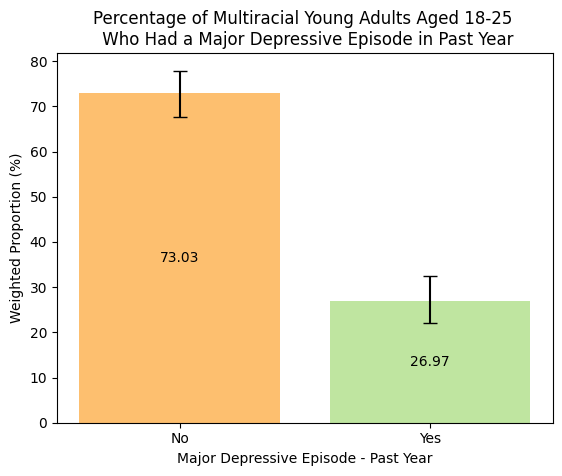

,variable,category,PopParam.prop,stderror,lower_ci,upper_ci,Percentage,Lower_ci_percentage,Upper_ci_percentage,lower_error,upper_error
0,subpop_xvar,No,0.730323,0.025702,0.675714,0.778747,73.032313,67.571422,77.874714,5.460891,4.842400
1,subpop_xvar,Yes,0.269677,0.025702,0.221253,0.324286,26.967687,22.125286,32.428578,4.842400,5.460891


In [368]:
#Examine past year major depressive episode frequencies among multiracial young adults aged 18-25
rel_freq_barplot(nsduh_2023,'IRAMDEYR','Major Depressive Episode - Past Year',0,"Percentage of Multiracial Young Adults Aged 18-25 \n Who Had a Major Depressive Episode in Past Year")

In [369]:
#Compute counts/frequencies (weighted to represent the totals for multiracial young adults in the U.S. population)
frequencies(nsduh_2023,'IRAMDEYR',na_rm=True)

,variable,category,PopParam.count,stderror,lower_ci,upper_ci
0,subpop_xvar,No,815142.992607,45406.989461,723940.370172,906345.615043
1,subpop_xvar,Yes,300997.187653,35262.329940,230170.713539,371823.661767


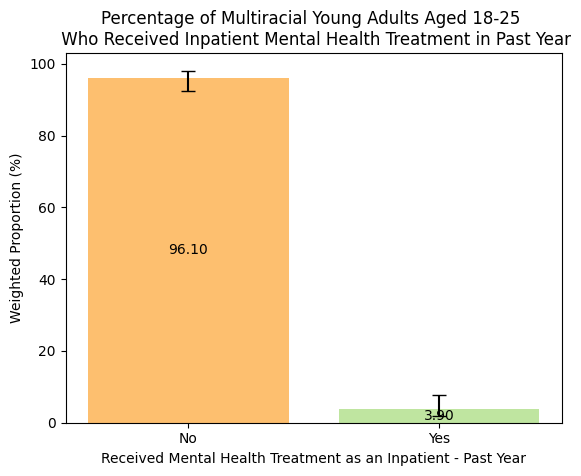

,variable,category,PopParam.prop,stderror,lower_ci,upper_ci,Percentage,Lower_ci_percentage,Upper_ci_percentage,lower_error,upper_error
0,subpop_xvar,No,0.961022,0.013488,0.922852,0.980702,96.102183,92.285233,98.070154,3.816950,1.967971
1,subpop_xvar,Yes,0.038978,0.013488,0.019298,0.077148,3.897817,1.929846,7.714767,1.967971,3.816950


In [370]:
#Examine past year receipt of inpatient mental health treatment frequencies among multiracial young adults aged 18-25
rel_freq_barplot(nsduh_2023,'MHTINPPY','Received Mental Health Treatment as an Inpatient - Past Year',0,"Percentage of Multiracial Young Adults Aged 18-25 \n Who Received Inpatient Mental Health Treatment in Past Year")

In [371]:
#Compute counts/frequencies (weighted to represent the totals for multiracial young adults in the U.S. population)
frequencies(nsduh_2023,'MHTINPPY',na_rm=True)

,variable,category,PopParam.count,stderror,lower_ci,upper_ci
0,subpop_xvar,No,1.072635e+06,52063.321327,968062.816153,1.177207e+06
1,subpop_xvar,Yes,4.350511e+04,15899.474828,11570.070607,7.544014e+04


# Initial Associations Between Substance Use and Mental Health

In this section, we accomplish goal 3 outlined in the introduction.

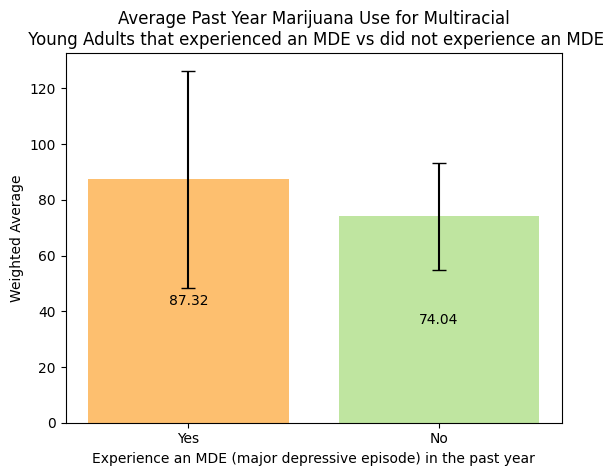

,_param,_domain,_estimate,_stderror,_lci,_uci,_cv,lower_error,upper_error
1,PopParam.mean,Yes,87.324242,19.432297,48.293325,126.355160,0.222530,39.030918,39.030918
1,PopParam.mean,No,74.041021,9.519745,54.920050,93.161992,0.128574,19.120971,19.120971


In [396]:
#Estimate average yearly marijuana use among multiracial young adults who experienced an MDE in the past year
#vs multiracial young adults who did not experience an MDE in the past year
mean_comp2(nsduh_2023,'IRMJFY','IRAMDEYR','Experience an MDE (major depressive episode) in the past year',0,'Average Past Year Marijuana Use for Multiracial\n Young Adults that experienced an MDE vs did not experience an MDE')

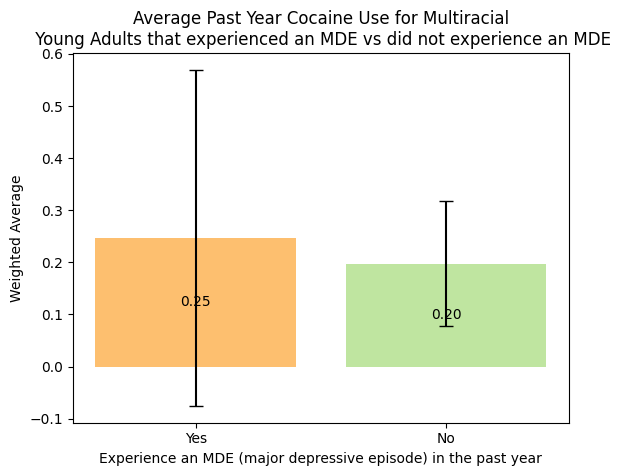

,_param,_domain,_estimate,_stderror,_lci,_uci,_cv,lower_error,upper_error
1,PopParam.mean,Yes,0.246855,0.160533,-0.075586,0.569296,0.650316,0.322441,0.322441
1,PopParam.mean,No,0.197522,0.059508,0.077998,0.317047,0.301270,0.119524,0.119524


In [397]:
#Estimate average yearly cocaine use among multiracial young adults who experienced an MDE in the past year
#vs multiracial young adults who did not experience an MDE in the past year
mean_comp2(nsduh_2023,'IRCOCFY','IRAMDEYR','Experience an MDE (major depressive episode) in the past year',0,'Average Past Year Cocaine Use for Multiracial\n Young Adults that experienced an MDE vs did not experience an MDE')

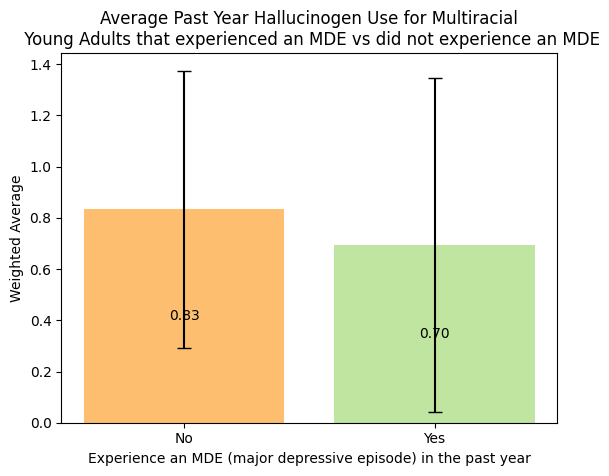

,_param,_domain,_estimate,_stderror,_lci,_uci,_cv,lower_error,upper_error
1,PopParam.mean,No,0.832762,0.269800,0.290853,1.374671,0.323982,0.541909,0.541909
1,PopParam.mean,Yes,0.695483,0.324871,0.042961,1.348004,0.467115,0.652522,0.652522


In [398]:
#Estimate average yearly hallucinogen use among multiracial young adults who experienced an MDE in the past year
#vs multiracial young adults who did not experience an MDE in the past year
mean_comp2(nsduh_2023,'IRHALLUCYFQ','IRAMDEYR','Experience an MDE (major depressive episode) in the past year',0,'Average Past Year Hallucinogen Use for Multiracial\n Young Adults that experienced an MDE vs did not experience an MDE')

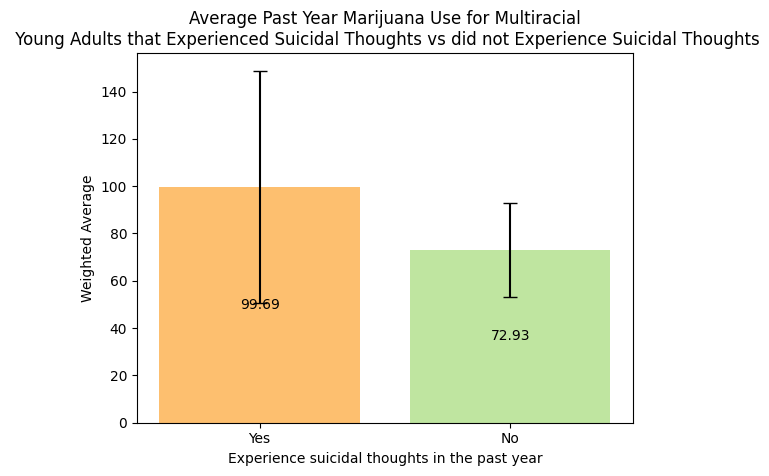

,_param,_domain,_estimate,_stderror,_lci,_uci,_cv,lower_error,upper_error
1,PopParam.mean,Yes,99.689924,24.444243,50.592217,148.787631,0.245203,49.097707,49.097707
1,PopParam.mean,No,72.932140,9.856595,53.134587,92.729693,0.135147,19.797553,19.797553


In [399]:
#Estimate average yearly marijuana use among multiracial young adults who experienced suicidal thoughts in the past year
#vs multiracial young adults who did not experience suicidal thoughts in the past year
mean_comp2(nsduh_2023,'IRMJFY','IRSUICTHNK','Experience suicidal thoughts in the past year',0,'Average Past Year Marijuana Use for Multiracial\n Young Adults that Experienced Suicidal Thoughts vs did not Experience Suicidal Thoughts')

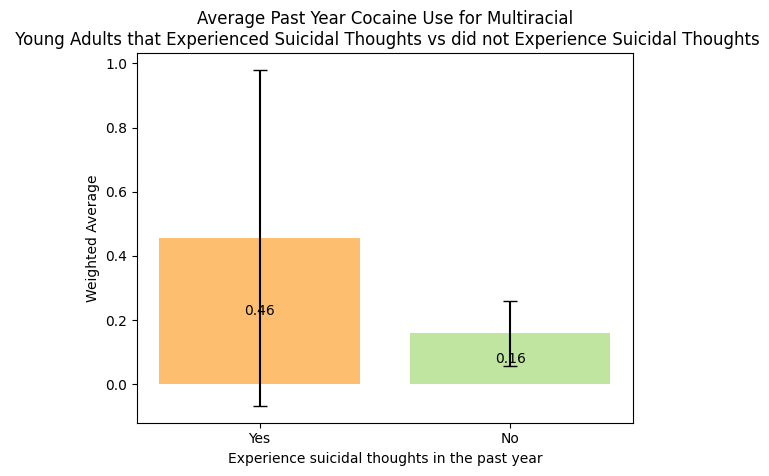

,_param,_domain,_estimate,_stderror,_lci,_uci,_cv,lower_error,upper_error
1,PopParam.mean,Yes,0.456148,0.260501,-0.067082,0.979379,0.571087,0.523231,0.523231
1,PopParam.mean,No,0.158674,0.051065,0.056108,0.261241,0.321821,0.102567,0.102567


In [400]:
#Estimate average yearly cocaine use among multiracial young adults who experienced suicidal thoughts in the past year
#vs multiracial young adults who did not experience suicidal thoughts in the past year
mean_comp2(nsduh_2023,'IRCOCFY','IRSUICTHNK','Experience suicidal thoughts in the past year',0,'Average Past Year Cocaine Use for Multiracial\n Young Adults that Experienced Suicidal Thoughts vs did not Experience Suicidal Thoughts')

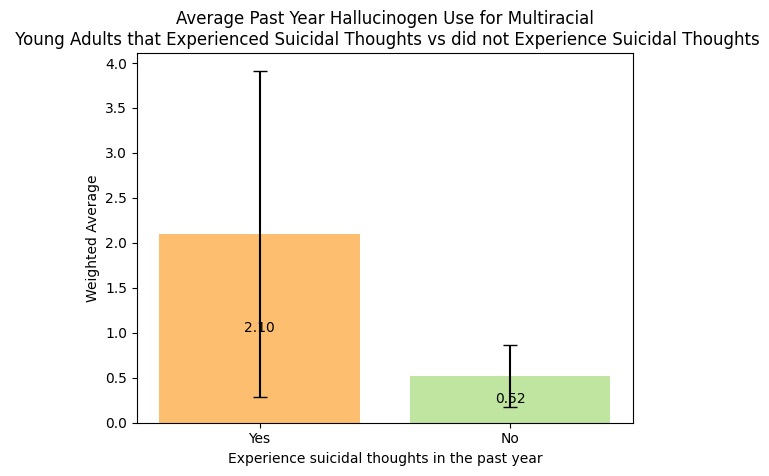

,_param,_domain,_estimate,_stderror,_lci,_uci,_cv,lower_error,upper_error
1,PopParam.mean,Yes,2.098250,0.904204,0.282102,3.914397,0.430933,1.816147,1.816147
1,PopParam.mean,No,0.518847,0.173111,0.171144,0.866550,0.333645,0.347703,0.347703


In [401]:
#Estimate average yearly hallucinogen use among multiracial young adults who experienced suicidal thoughts in the past year
#vs multiracial young adults who did not experience suicidal thoughts in the past year
mean_comp2(nsduh_2023,'IRHALLUCYFQ','IRSUICTHNK','Experience suicidal thoughts in the past year',0,'Average Past Year Hallucinogen Use for Multiracial\n Young Adults that Experienced Suicidal Thoughts vs did not Experience Suicidal Thoughts')

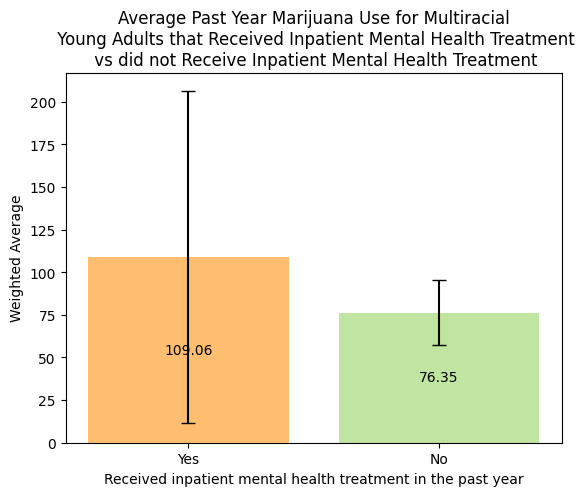

,_param,_domain,_estimate,_stderror,_lci,_uci,_cv,lower_error,upper_error
1,PopParam.mean,Yes,109.06494,48.489141,11.671634,206.458245,0.444590,97.393306,97.393306
1,PopParam.mean,No,76.34795,9.558208,57.149725,95.546175,0.125193,19.198225,19.198225


In [403]:
#Estimate average yearly marijuana use among multiracial young adults who received inpatient mental health treatment in the past year
#vs multiracial young adults who did not receive inpatient mental health treatment
mean_comp2(nsduh_2023,'IRMJFY','MHTINPPY','Received inpatient mental health treatment in the past year',0,'Average Past Year Marijuana Use for Multiracial\n Young Adults that Received Inpatient Mental Health Treatment\n vs did not Receive Inpatient Mental Health Treatment')

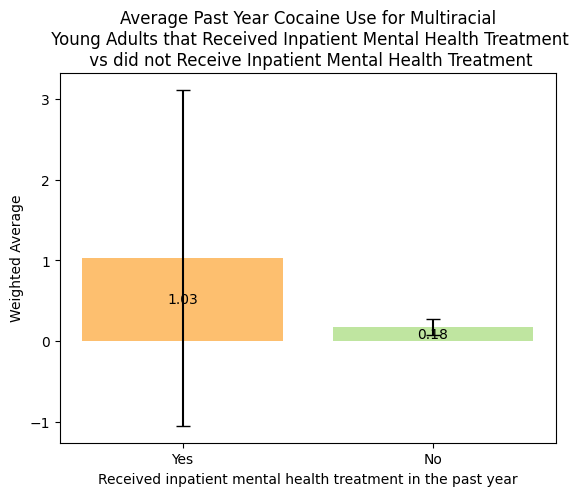

,_param,_domain,_estimate,_stderror,_lci,_uci,_cv,lower_error,upper_error
1,PopParam.mean,Yes,1.030667,1.035640,-1.049477,3.110810,1.004825,2.080144,2.080144
1,PopParam.mean,No,0.177574,0.050998,0.075142,0.280007,0.287193,0.102433,0.102433


In [404]:
#Estimate average yearly cocaine use among multiracial young adults who received inpatient mental health treatment in the past year
#vs multiracial young adults who did not receive inpatient mental health treatment
mean_comp2(nsduh_2023,'IRCOCFY','MHTINPPY','Received inpatient mental health treatment in the past year',0,'Average Past Year Cocaine Use for Multiracial\n Young Adults that Received Inpatient Mental Health Treatment\n vs did not Receive Inpatient Mental Health Treatment')

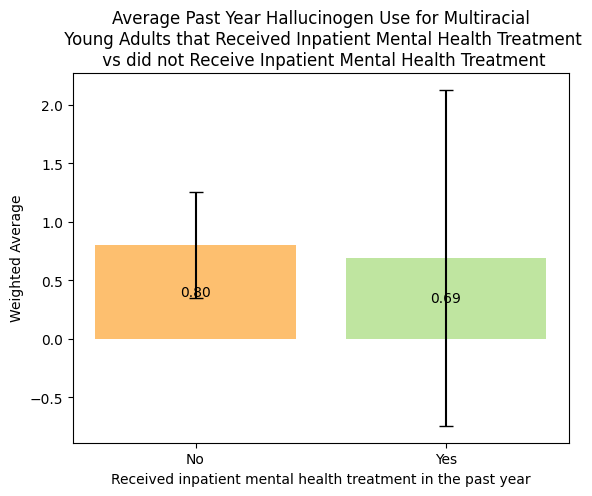

,_param,_domain,_estimate,_stderror,_lci,_uci,_cv,lower_error,upper_error
1,PopParam.mean,No,0.799984,0.225949,0.346152,1.253816,0.282442,0.453832,0.453832
1,PopParam.mean,Yes,0.691127,0.715038,-0.745069,2.127324,1.034597,1.436196,1.436196


In [405]:
#Estimate average yearly hallucinogen use among multiracial young adults who received inpatient mental health treatment in the past year
#vs multiracial young adults who did not receive inpatient mental health treatment
mean_comp2(nsduh_2023,'IRHALLUCYFQ','MHTINPPY','Received inpatient mental health treatment in the past year',0,'Average Past Year Hallucinogen Use for Multiracial\n Young Adults that Received Inpatient Mental Health Treatment\n vs did not Receive Inpatient Mental Health Treatment')

# 